In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import (ConfusionMatrixDisplay, 
                            confusion_matrix, 
                            precision_score, 
                            recall_score, 
                            f1_score, 
                            accuracy_score, 
                            classification_report)
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

from data_transform import ColumnDropper, CategorizerFeatures, OrdinalEncoderTransformer, OneHotEmbarkedAndPclassEncoder

In [2]:
df = pd.read_csv('dataset/titanicc/train.csv')

In [3]:
y = df['Survived']

In [4]:
colunas = ["PassengerId","Pclass","Name","Sex","Age","SibSp","Parch","Ticket","Fare","Cabin","Embarked"]

In [5]:
X = df[colunas]

In [6]:
X_test_final = pd.read_csv("dataset/titanicc/test.csv")

In [7]:
y_test_final = pd.read_csv('dataset/titanicc/gender_submission.csv')

In [8]:
y_test_final = y_test_final['Survived'].to_numpy()

In [9]:
ppl_transform = Pipeline([
    ('drop_columns', ColumnDropper(columns_to_drop=['Cabin', 'Name', 'Ticket'])),
    ('CategorizerFeatures', CategorizerFeatures()),
    ('ordinal_encoder', OrdinalEncoderTransformer(columns=['Sex'])),
    ('encoder', OneHotEmbarkedAndPclassEncoder()),
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('scaler', StandardScaler()), 
])

In [10]:

logit = LogisticRegression(max_iter=1000)

param_grid = {
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga'],  # necessário para suportar 'l1'
    'C': [0.01, 0.1, 1, 10]           # força da regularização
}

# GridSearchCV
grid_search = GridSearchCV(logit, param_grid, cv=5, scoring='accuracy')
X_ppl_logit=ppl_transform.fit_transform(X)
grid_search.fit(X_ppl_logit, y)

# Mostrar melhores parâmetros
print("Melhores parâmetros:", grid_search.best_params_)

# Usar os melhores parâmetros para criar novo modelo
logit_params = grid_search.best_params_
best_model = LogisticRegression(**logit_params, max_iter=1000)
best_model.fit(X_ppl_logit, y)



Melhores parâmetros: {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}


LogisticRegression(C=1, max_iter=1000, solver='liblinear')

In [11]:
model = make_pipeline(ppl_transform,LogisticRegression(**logit_params) )

In [12]:
model.fit(X,y)

y_pred_logit = model.predict(X_test_final)

print(classification_report(y_test_final, y_pred_logit))

              precision    recall  f1-score   support

           0       0.96      0.93      0.94       266
           1       0.88      0.93      0.90       152

    accuracy                           0.93       418
   macro avg       0.92      0.93      0.92       418
weighted avg       0.93      0.93      0.93       418



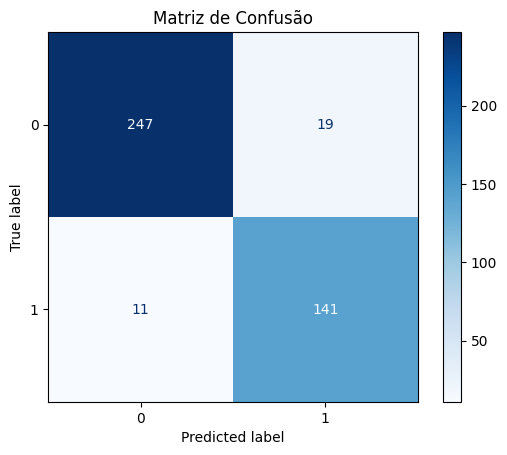

In [13]:
ConfusionMatrixDisplay.from_predictions(y_test_final, y_pred_logit, cmap='Blues')
plt.title("Matriz de Confusão")
plt.show()